# AAAI 2026 Tutorial: A Decade of Sparse Training

## Dynamic Sparse Training (DST) Tutorial

This notebook demonstrates Dynamic Sparse Training concepts and implementations.

**Learning Objectives:**
1. Understand the difference between simulated and truly sparse implementations
2. Implement DST algorithms from scratch
3. Experience the performance-efficiency trade-offs
4. Recognize system-level barriers to sparse training adoption

**Dataset:** MNIST (handwritten digits)
- 60,000 training samples, 10,000 test samples
- 28x28 grayscale images, 10 classes


In [1]:
!git clone https://github.com/JafarBadour/aaai-lab-decade-of-sparsity-supervised-learning.git

Cloning into 'aaai-lab-decade-of-sparsity-supervised-learning'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 5 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (5/5), 13.06 KiB | 13.06 MiB/s, done.


In [2]:
%cd ./aaai-lab-decade-of-sparsity-supervised-learning

/content/aaai-lab-decade-of-sparsity-supervised-learning


In [3]:
!pip install -r requirements.txt

In [4]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import copy

# Import utilities from utils.py
from utils import (
    SimpleNet, MaskedNet,
    train_epoch, evaluate,
    apply_dst_step,
    benchmark_inference,
    plot_mask_2d_evolution,
    plot_dense_vs_masked_comparison,
    CUPY_GPU_AVAILABLE
)

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
print(f"CuPy GPU available: {CUPY_GPU_AVAILABLE}")


✓ All imports successful!
PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: Tesla T4
CuPy GPU available: True


## Configuration

Set hyperparameters and global settings here.


In [5]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Inform about CuPy GPU availability
if CUPY_GPU_AVAILABLE:
    print(f"✓ CuPy GPU acceleration available - will use GPU CSR matrices")
else:
    print(f"⚠ CuPy GPU not available - will use CPU CSR matrices")

# Hyperparameters
GLOBAL_SPARSITY = 0.95  # 95% sparsity (adjust to experiment)
batch_size = 64
num_epochs = 10
learning_rate = 0.001
dst_frequency = 2  # Apply DST every N epochs

print(f"\nHyperparameters:")
print(f"  Sparsity: {GLOBAL_SPARSITY*100}%")
print(f"  Batch size: {batch_size}")
print(f"  Epochs: {num_epochs}")
print(f"  Learning rate: {learning_rate}")
print(f"  DST frequency: every {dst_frequency} epochs")


Using device: cuda
✓ CuPy GPU acceleration available - will use GPU CSR matrices

Hyperparameters:
  Sparsity: 95.0%
  Batch size: 64
  Epochs: 10
  Learning rate: 0.001
  DST frequency: every 2 epochs


## Step 1: Load MNIST Dataset


In [6]:
# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Download and load training data
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2 if torch.cuda.is_available() else 0
)

# Download and load test data
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2 if torch.cuda.is_available() else 0
)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image size: {train_dataset[0][0].shape}")
print(f"Number of classes: {len(train_dataset.classes)}")


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.55MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 128kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.26MB/s]

Training samples: 60000
Test samples: 10000
Image size: torch.Size([1, 28, 28])
Number of classes: 10


## Step 2: Create Networks


In [7]:
# Create base network
base_net = SimpleNet(num_classes=10)
print(f"Base network created with {sum(p.numel() for p in base_net.parameters())} parameters")

# Create dense network (copy of base)
dense_net = copy.deepcopy(base_net).to(device)

# Create masked network
print(f"\nCreating masked network with {GLOBAL_SPARSITY*100}% sparsity")
masked_net = MaskedNet(base_net, sparsity=GLOBAL_SPARSITY).to(device)

# Print sparsity statistics
stats = masked_net.get_sparsity_stats()
print("\nSparsity Statistics:")
for name, stat in stats.items():
    print(f"  {name}: {stat['sparsity']*100:.2f}% sparse ({stat['zeros']}/{stat['total']} zeros)")

# Loss and optimizers
criterion = nn.CrossEntropyLoss()
dense_optimizer = optim.Adam(dense_net.parameters(), lr=learning_rate)
masked_optimizer = optim.Adam(masked_net.parameters(), lr=learning_rate)


Base network created with 1345642 parameters

Creating masked network with 95.0% sparsity

Sparsity Statistics:
  conv1: 94.44% sparse (136/144 zeros)
  conv2: 94.99% sparse (4377/4608 zeros)
  fc1: 95.00% sparse (190668/200704 zeros)
  fc2: 95.00% sparse (121600/128000 zeros)
  fc3: 95.00% sparse (950000/1000000 zeros)
  fc4: 95.00% sparse (9500/10000 zeros)


## Step 3: Training Loop

Train both dense and masked networks, applying Dynamic Sparse Training periodically.


In [8]:
# Track metrics for both networks
dense_train_losses = []
dense_train_accs = []
dense_test_losses = []
dense_test_accs = []

masked_train_losses = []
masked_train_accs = []
masked_test_losses = []
masked_test_accs = []
sparsity_per_epoch = []  # Track sparsity per layer per epoch
masks_per_epoch = []  # Track actual mask values per epoch for visualization

print("="*60)
print("Training Dense and Dense+Mask Networks")
print("="*60)

for epoch in range(num_epochs):
    # Train dense network
    dense_train_loss, dense_train_acc = train_epoch(dense_net, train_loader, criterion, dense_optimizer, device)
    dense_train_losses.append(dense_train_loss)
    dense_train_accs.append(dense_train_acc)
    dense_test_acc, dense_test_loss = evaluate(dense_net, test_loader, device, criterion)
    dense_test_accs.append(dense_test_acc)
    dense_test_losses.append(dense_test_loss)

    # Train masked network
    masked_train_loss, masked_train_acc = train_epoch(masked_net, train_loader, criterion, masked_optimizer, device)
    masked_train_losses.append(masked_train_loss)
    masked_train_accs.append(masked_train_acc)
    masked_test_acc, masked_test_loss = evaluate(masked_net, test_loader, device, criterion)
    masked_test_accs.append(masked_test_acc)
    masked_test_losses.append(masked_test_loss)

    # Track sparsity per epoch (per layer)
    stats = masked_net.get_sparsity_stats()
    sparsity_dict = {name: stat['sparsity'] for name, stat in stats.items()}
    sparsity_per_epoch.append(sparsity_dict)

    # Track mask values per epoch for visualization
    masks_2d = masked_net.get_masks_as_2d()
    masks_per_epoch.append(masks_2d)

    # Apply DST periodically
    if (epoch + 1) % dst_frequency == 0:
        print(f"\nEpoch {epoch+1}: Applying Dynamic Sparse Training...")
        apply_dst_step(masked_net, prune_ratio=0.1)

        # Update sparsity statistics
        stats = masked_net.get_sparsity_stats()
        avg_sparsity = np.mean([s['sparsity'] for s in stats.values()])

        print(f"  Average sparsity after DST: {avg_sparsity*100:.2f}%")

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Dense:      Train Loss: {dense_train_loss:.4f}, Train Acc: {dense_train_acc:.2f}%, Test Loss: {dense_test_loss:.4f}, Test Acc: {dense_test_acc:.2f}%")
    print(f"  Dense+Mask: Train Loss: {masked_train_loss:.4f}, Train Acc: {masked_train_acc:.2f}%, Test Loss: {masked_test_loss:.4f}, Test Acc: {masked_test_acc:.2f}%")
    print(f"  Difference: Loss Δ: {masked_test_loss - dense_test_loss:+.4f}, Acc Δ: {masked_test_acc - dense_test_acc:+.2f}%")

print("\n✓ Training complete!")


Training Dense and Dense+Mask Networks
Epoch [1/10]
  Dense:      Train Loss: 0.1597, Train Acc: 94.95%, Test Loss: 0.0494, Test Acc: 98.50%
  Dense+Mask: Train Loss: 0.9212, Train Acc: 67.76%, Test Loss: 0.3360, Test Acc: 89.39%
  Difference: Loss Δ: +0.2866, Acc Δ: -9.11%

Epoch 2: Applying Dynamic Sparse Training...
  Average sparsity after DST: 94.91%
Epoch [2/10]
  Dense:      Train Loss: 0.0525, Train Acc: 98.43%, Test Loss: 0.0532, Test Acc: 98.44%
  Dense+Mask: Train Loss: 0.2822, Train Acc: 91.11%, Test Loss: 0.2380, Test Acc: 92.72%
  Difference: Loss Δ: +0.1848, Acc Δ: -5.72%
Epoch [3/10]
  Dense:      Train Loss: 0.0394, Train Acc: 98.88%, Test Loss: 0.0347, Test Acc: 98.93%
  Dense+Mask: Train Loss: 0.2200, Train Acc: 93.19%, Test Loss: 0.1906, Test Acc: 94.10%
  Difference: Loss Δ: +0.1559, Acc Δ: -4.83%

Epoch 4: Applying Dynamic Sparse Training...
  Average sparsity after DST: 94.91%
Epoch [4/10]
  Dense:      Train Loss: 0.0318, Train Acc: 99.12%, Test Loss: 0.0448, Te

## Step 4: Final Evaluation


In [9]:
final_test_acc_dense, final_test_loss_dense = evaluate(dense_net, test_loader, device, criterion)
final_test_acc_masked, final_test_loss_masked = evaluate(masked_net, test_loader, device, criterion)

print("="*60)
print("Final Test Results")
print("="*60)
print(f"  Dense:      Loss: {final_test_loss_dense:.4f}, Acc: {final_test_acc_dense:.2f}%")
print(f"  Dense+Mask: Loss: {final_test_loss_masked:.4f}, Acc: {final_test_acc_masked:.2f}%")
print(f"  Difference: Loss Δ: {final_test_loss_masked - final_test_loss_dense:+.4f}, Acc Δ: {final_test_acc_masked - final_test_acc_dense:+.2f}%")

final_stats = masked_net.get_sparsity_stats()
print("\nFinal Sparsity Statistics:")
for name, stat in final_stats.items():
    print(f"  {name}: {stat['sparsity']*100:.2f}% sparse ({stat['zeros']}/{stat['total']} zeros)")


Final Test Results
  Dense:      Loss: 0.0449, Acc: 98.98%
  Dense+Mask: Loss: 0.0992, Acc: 96.71%
  Difference: Loss Δ: +0.0543, Acc Δ: -2.27%

Final Sparsity Statistics:
  conv1: 94.44% sparse (136/144 zeros)
  conv2: 94.99% sparse (4377/4608 zeros)
  fc1: 95.00% sparse (190668/200704 zeros)
  fc2: 95.00% sparse (121600/128000 zeros)
  fc3: 95.00% sparse (950000/1000000 zeros)
  fc4: 95.00% sparse (9500/10000 zeros)


## Step 5: Generate Visualizations


In [25]:
print("="*60)
print("Generating plots...")
print("="*60)

# Plot 2D mask evolution as images
plot_mask_2d_evolution(masks_per_epoch, save_path='plots/mask_2d_evolution.png')

# Plot dense vs masked comparison
plot_dense_vs_masked_comparison(
    dense_train_losses, dense_train_accs, dense_test_losses, dense_test_accs,
    masked_train_losses, masked_train_accs, masked_test_losses, masked_test_accs,
    save_path='plots/dense_vs_masked.png'
)

print("\n✓ All plots saved to 'plots/' directory")


Generating plots...
✓ Saved 2D mask evolution for conv1 to plots/mask_2d_evolution_conv1.png
✓ Saved 2D mask evolution for conv2 to plots/mask_2d_evolution_conv2.png
✓ Saved 2D mask evolution for fc1 to plots/mask_2d_evolution_fc1.png
✓ Saved 2D mask evolution for fc2 to plots/mask_2d_evolution_fc2.png
✓ Saved 2D mask evolution for fc3 to plots/mask_2d_evolution_fc3.png
✓ Saved 2D mask evolution for fc4 to plots/mask_2d_evolution_fc4.png

✓ Generated 2D mask evolution plots for 6 layers
✓ Saved dense vs masked comparison plot to plots/dense_vs_masked.png

✓ All plots saved to 'plots/' directory


Displaying plots from './plots':

--- dense_vs_masked.png ---


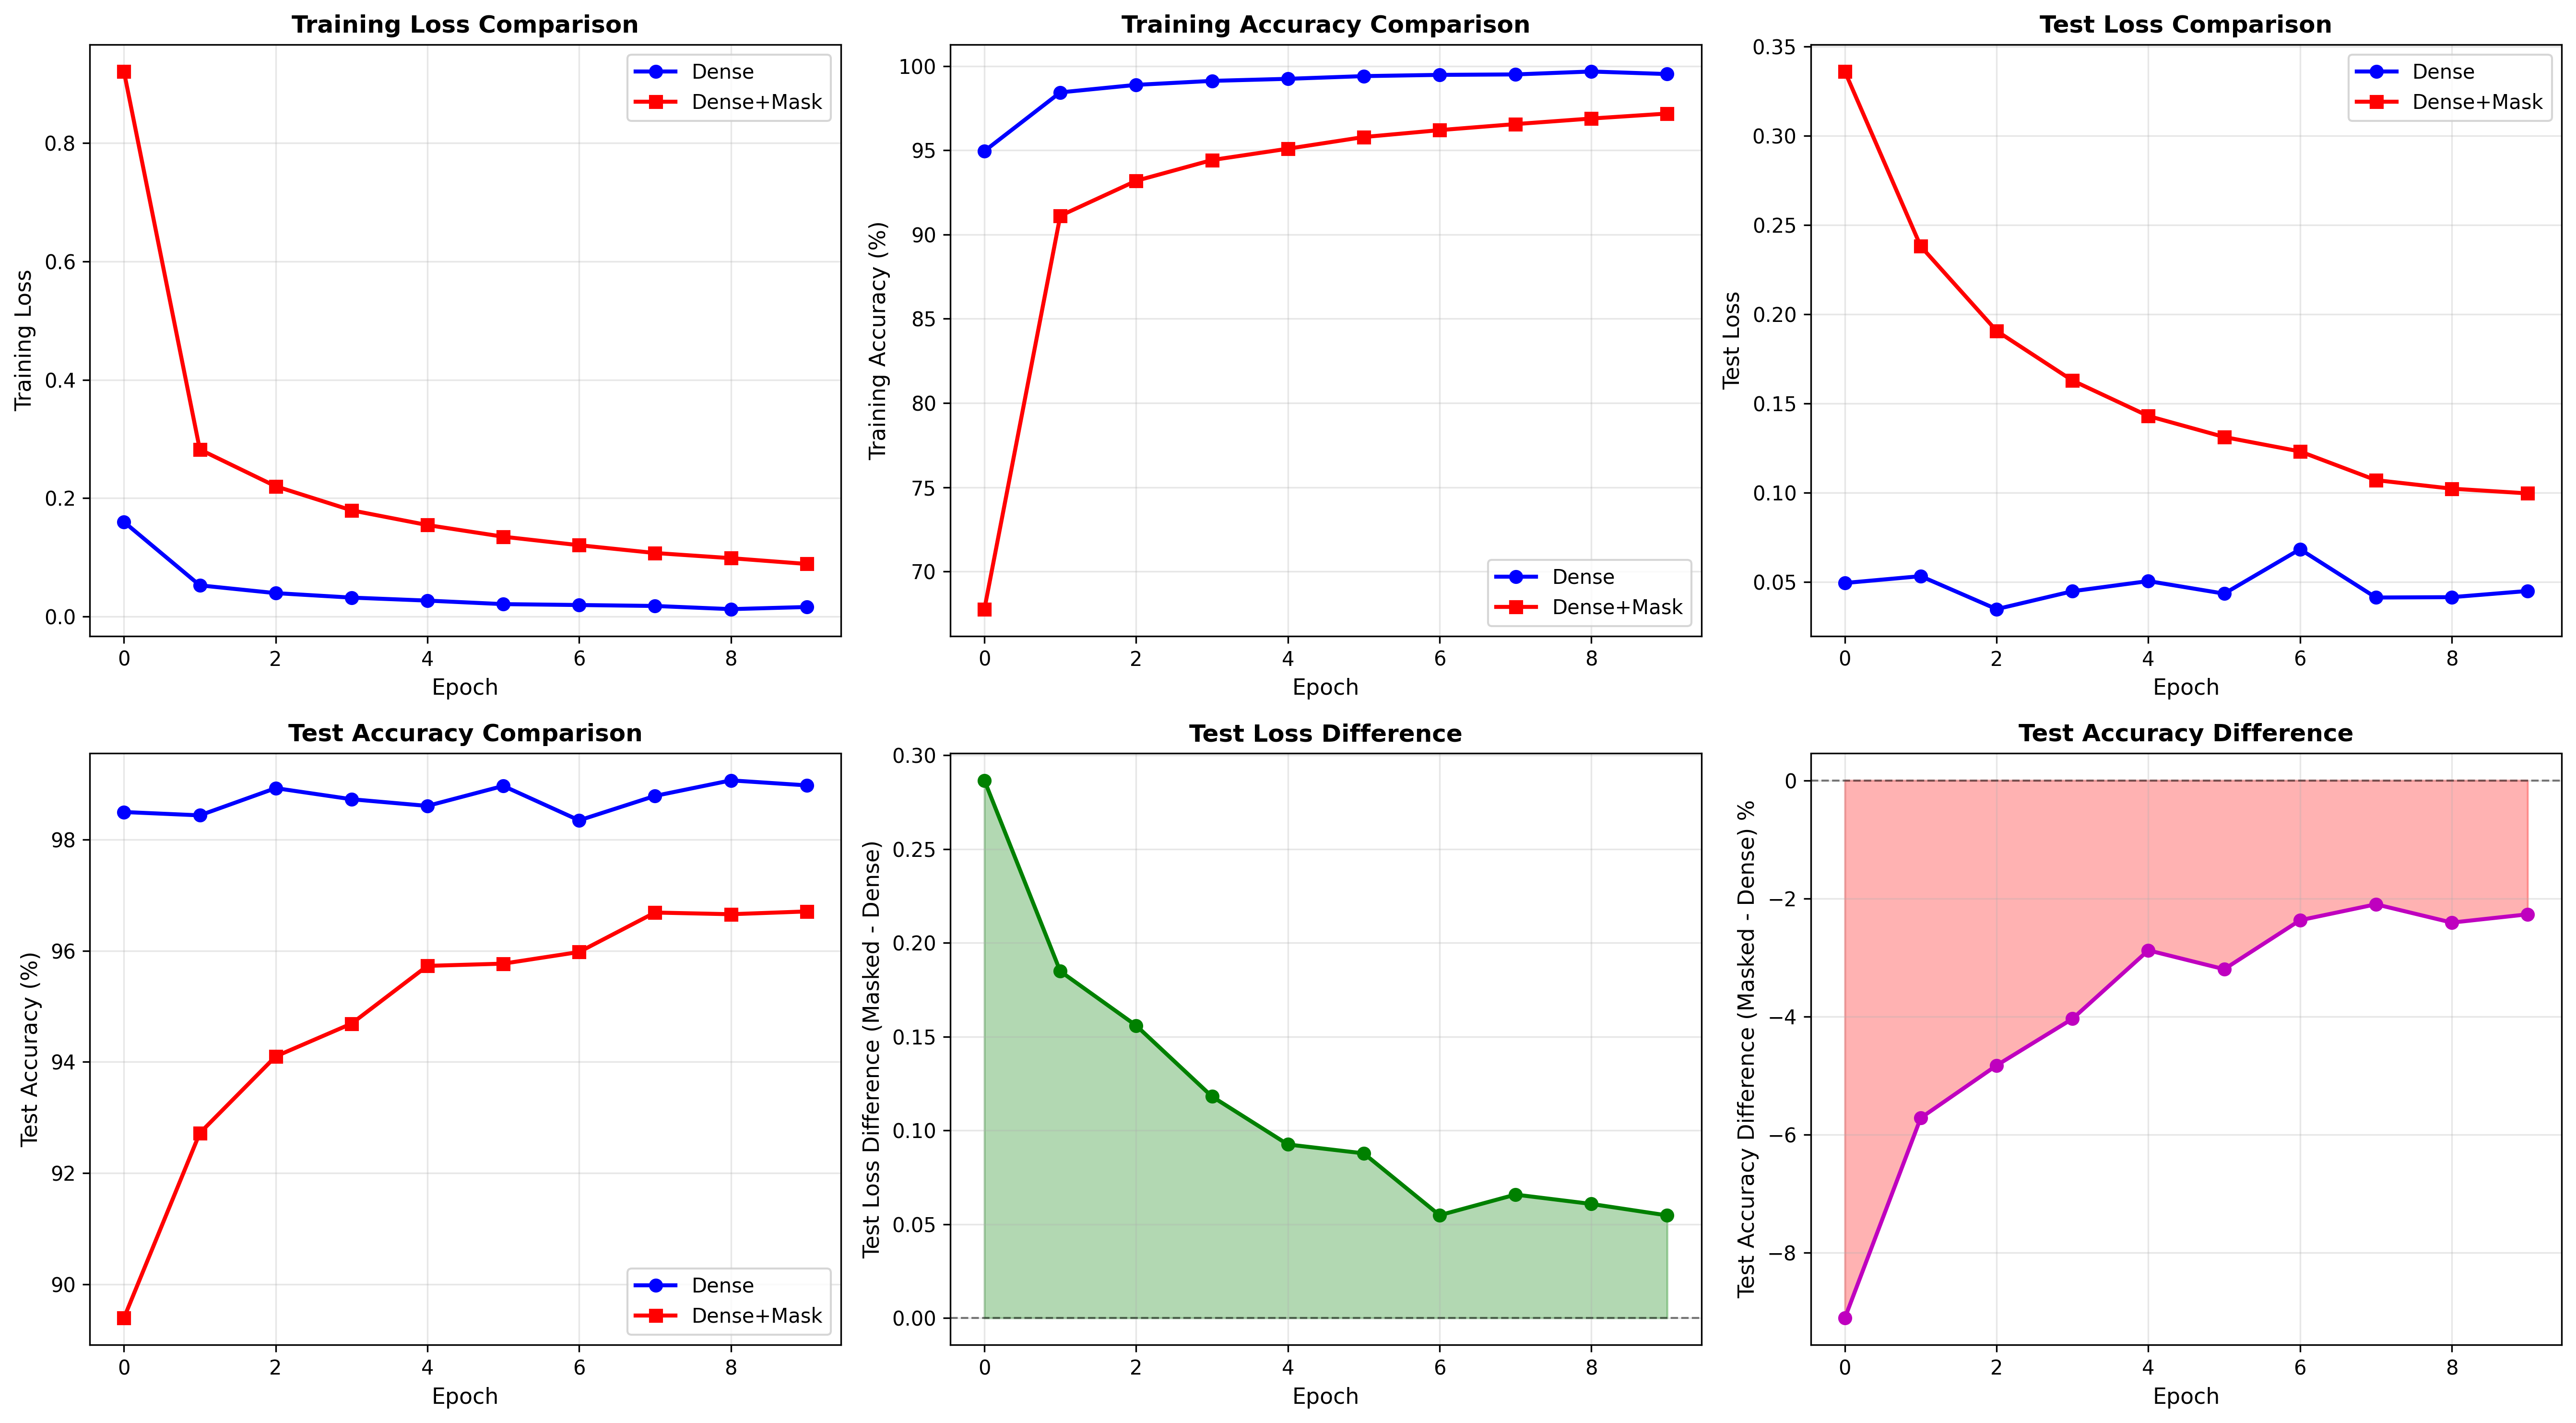


--- mask_2d_evolution_fc1.png ---


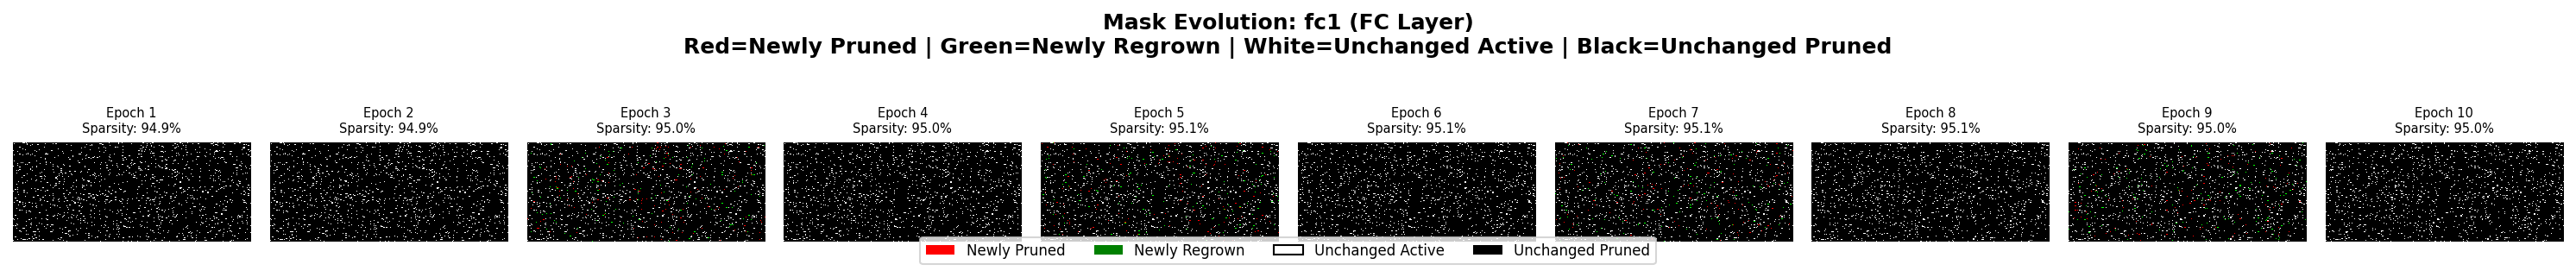


--- mask_2d_evolution_fc2.png ---


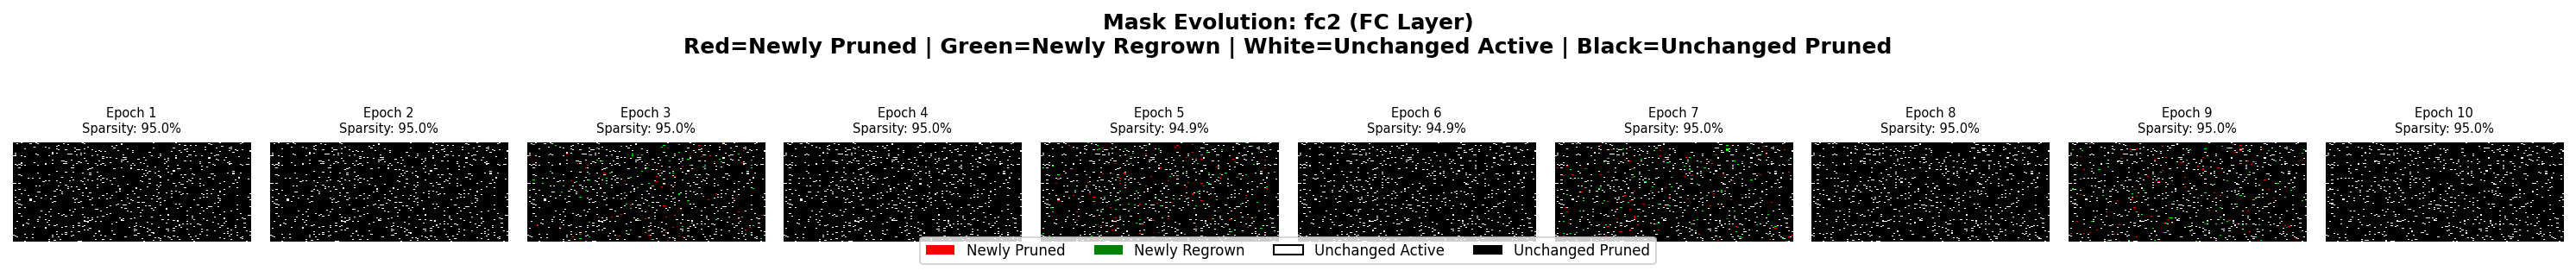


--- mask_2d_evolution_fc3.png ---


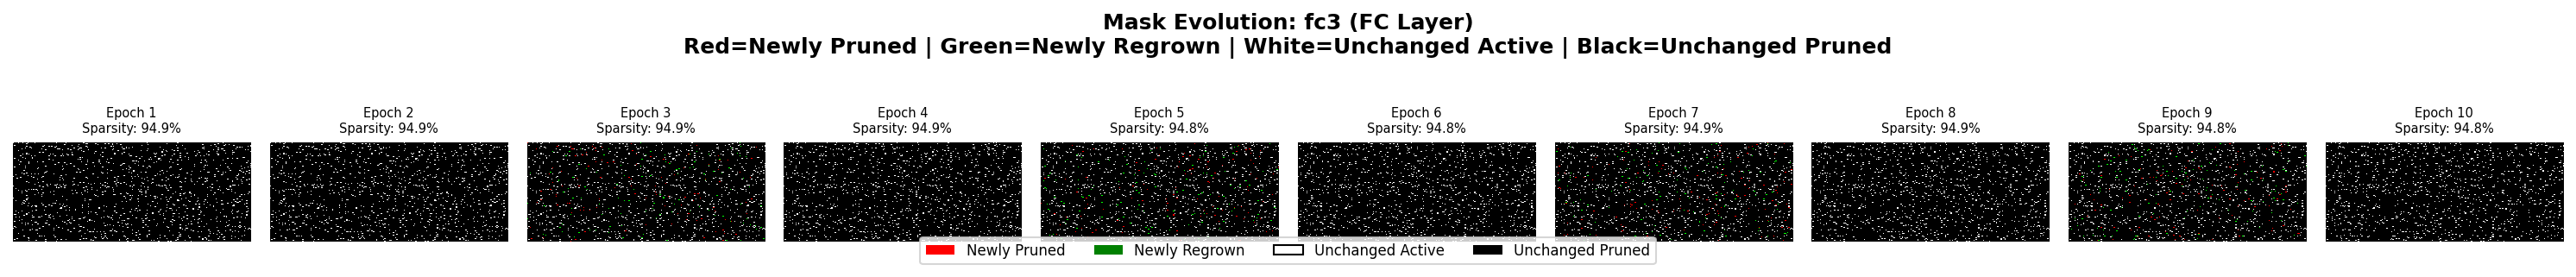


--- mask_2d_evolution_fc4.png ---


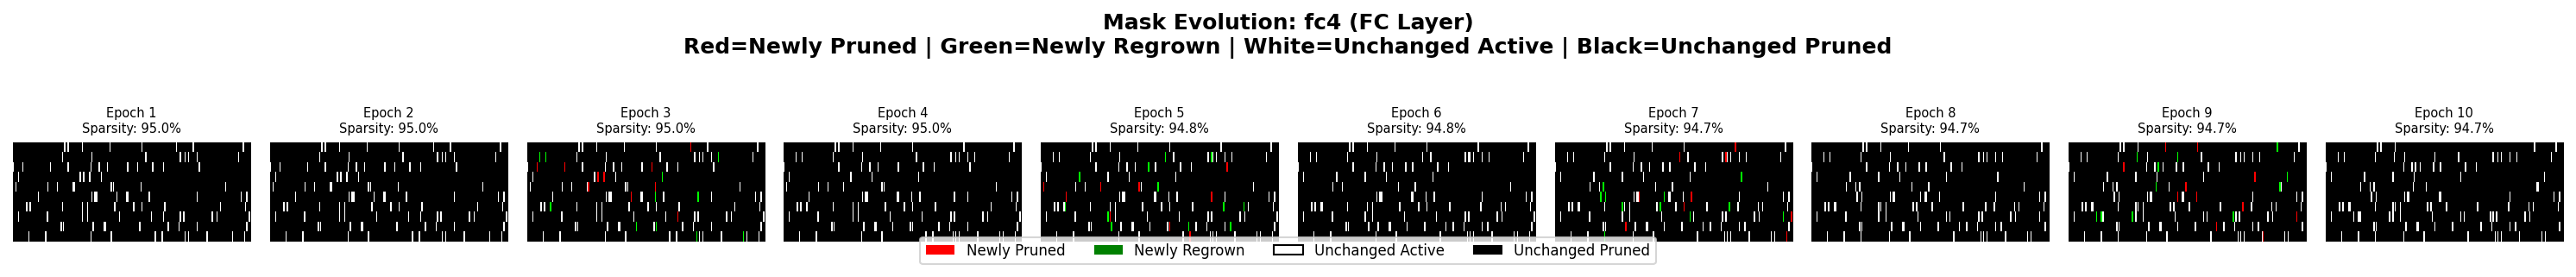

In [26]:
from IPython.display import Image, display
import os

plot_dir = './plots'
plot_files = [
    'dense_vs_masked.png'
]

# Add individual 2D mask evolution plots dynamically, excluding conv layers
for name, stat in final_stats.items():
    if not name.startswith('conv'):
        plot_files.append(f'mask_2d_evolution_{name}.png')

print(f"Displaying plots from '{plot_dir}':")

for plot_file in plot_files:
    path = os.path.join(plot_dir, plot_file)
    if os.path.exists(path):
        print(f"\n--- {plot_file} ---")
        display(Image(filename=path))
    else:
        print(f"Warning: Plot file not found at {path}")


## Step 6: Benchmarking - Simulated vs Truly Sparse

Compare inference time for different implementations to demonstrate the difference between simulated and truly sparse approaches.


In [11]:
print("="*60)
print("Benchmarking - Simulated vs Truly Sparse")
print("="*60)
print("\nComparing inference time for different implementations...")
print("(This demonstrates the difference between simulated and truly sparse)")

benchmark_results = benchmark_inference(masked_net, test_loader, device, num_samples=100)

print("\nInference Time Comparison (100 samples, 10 runs):")
print("-" * 60)
for method, timing in benchmark_results.items():
    print(f"{method:30s}: {timing['mean']:6.2f} ± {timing['std']:5.2f} ms")


Benchmarking - Simulated vs Truly Sparse

Comparing inference time for different implementations...
(This demonstrates the difference between simulated and truly sparse)

Converting to CSR sparse format...
Layer masked_fc1: shape=(128, 1568), nnz=10036/200704, sparsity=95.00%, on_gpu=False
Layer masked_fc2: shape=(1000, 128), nnz=6400/128000, sparsity=95.00%, on_gpu=False
Layer masked_fc3: shape=(1000, 1000), nnz=50000/1000000, sparsity=95.00%, on_gpu=False
Layer masked_fc4: shape=(10, 1000), nnz=500/10000, sparsity=95.00%, on_gpu=False

Sparsity Check:
✓ masked_fc1: 95.0% sparse
✓ masked_fc2: 95.0% sparse
✓ masked_fc3: 95.0% sparse
✓ masked_fc4: 95.0% sparse
Layer masked_fc1: shape=(128, 1568), nnz=10036/200704, sparsity=95.00%, on_gpu=True
Layer masked_fc2: shape=(1000, 128), nnz=6400/128000, sparsity=95.00%, on_gpu=True
Layer masked_fc3: shape=(1000, 1000), nnz=50000/1000000, sparsity=95.00%, on_gpu=True
Layer masked_fc4: shape=(10, 1000), nnz=500/10000, sparsity=95.00%, on_gpu=True

## Step 7: Speedup Analysis


In [27]:
print("="*60)
print("Speedup Analysis")
print("="*60)

# GPU comparison: GPU Dense+Mask vs GPU Truly Sparse (if available)
if 'Dense+Mask (GPU)' in benchmark_results and 'Truly Sparse CSR (GPU)' in benchmark_results:
    gpu_dense = benchmark_results['Dense+Mask (GPU)']['mean']
    gpu_sparse = benchmark_results['Truly Sparse CSR (GPU)']['mean']
    speedup = gpu_dense / gpu_sparse if gpu_sparse > 0 else 0
    print(f"\nMain Comparison: GPU Dense+Mask vs GPU Truly Sparse")
    print(f"  Dense+Mask (GPU): {gpu_dense:.2f} ms")
    print(f"  Truly Sparse CSR (GPU): {gpu_sparse:.2f} ms")
    if speedup > 1:
        print(f"  → GPU Truly Sparse is {speedup:.2f}x faster than GPU Dense+Mask!")
    elif speedup < 1:
        print(f"  → GPU Dense+Mask is {1/speedup:.2f}x faster")
    else:
        print(f"  → Similar performance")
    print(f"\n  Note: This demonstrates the gains of truly sparse slight slowdown in inference speed but drastic decrease in parameter count 95% reduction")
    print(f"        implementations on GPU using cuSPARSE acceleration.")


Speedup Analysis

Main Comparison: GPU Dense+Mask vs GPU Truly Sparse
  Dense+Mask (GPU): 0.68 ms
  Truly Sparse CSR (GPU): 1.04 ms
  → GPU Dense+Mask is 1.53x faster

  Note: This demonstrates the gains of truly sparse slight slowdown in inference speed but drastic decrease in parameter count 95% reduction
        implementations on GPU using cuSPARSE acceleration.


## Summary

### Key Concepts Demonstrated:
1. ✓ Simulated sparsity using binary masks (Dense+Mask)
2. ✓ Masked Conv2d and Linear layers
3. ✓ Dynamic Sparse Training (pruning + regrowing)
4. ✓ Gradient masking to prevent updates to pruned weights
5. ✓ Truly sparse implementation using CSR matrices
6. ✓ Benchmarking comparison: Dense+Mask vs Truly Sparse

### Understanding the Limitations

**THE PARADOX: Why Do We Still Stick to Dense Training?**

Despite DST being algorithmically mature and often outperforming dense training, most implementations remain dense. Here's why:

1. **SIMULATED SPARSITY (What We Just Implemented):**
   - Uses binary masks over dense weights
   - Convenient: works with existing frameworks
   - Problem: Still stores ALL weights in memory
   - Problem: Still computes with dense kernels
   - Result: NO memory savings, minimal speedup

2. **TRULY SPARSE IMPLEMENTATIONS:**
   - Uses sparse matrix formats (COO, CSR, CSC)
   - Stores only non-zero weights
   - Requires custom kernels for efficiency
   - Challenge: Hardware optimized for dense operations
   - Challenge: Requires significant engineering effort

3. **SYSTEM-LEVEL BARRIERS:**
   - Hardware: GPUs optimized for dense matrix multiplication
   - Software: Deep learning frameworks favor dense operations
   - Memory: Sparse formats have overhead for small sparsity
   - Engineering: Truly sparse implementations are complex

### Next Steps

- Understand sparse matrix formats and operations (COO, CSR, CSC)
- Consider hardware-aware sparsity patterns
- Join the sparse training community for collaboration

For more information, see the AAAI 2026 Tutorial:
**"A Decade of Sparse Training: Why Do We Still Stick to Dense Training?"**
